In [10]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(glue); library(lubridate); library(scales)
})


## Double Logged of Dialog Close Events

[Task](https://phabricator.wikimedia.org/T264690)

Dialog close events (dialog-insert, dialog-done, dialog-abort, etc) were all getting logged twice for node events (a node is any component that is not editable withing the page. Said another way: any component that requires a dialog to edit (e.g. reference, image, template). 

The  fix was deployed on 8 October 2020. 

Checks:
- Verify that dialog events are only logging once in the database
- There should be more open events then close events following the deployment date

In [113]:
# Collect vefu events

query <-
"SELECT
 date_format(dt, 'yyyy-MM-dd') AS date,
 event.editingSessionID AS sessionID,
 event.feature AS feature,
 If(event.action LIKE 'dialog-%', 'dialog_close_event', 'window_open_event') AS event_type,
 COUNT(*) as events
FROM
event.visualeditorfeatureuse
WHERE
-- fix deployed on 6 October 2020
    year = 2020 
    AND month = 10
-- review all dialog and window open actions
    AND (event.action IN ('dialog-done', 'dialog-insert', 'dialog-abort', 'dialog-remove') OR 
    event.action LIKE 'window-open-from-%')
-- remove bots
    AND useragent.is_bot = false 
GROUP BY
  date_format(dt, 'yyyy-MM-dd'),
  event.editingSessionID,
 event.feature,
  If(event.action LIKE 'dialog-%', 'dialog_close_event', 'window_open_event') 
"

In [114]:
collect_vefu_events <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [115]:
collect_vefu_events$date <- as.Date(collect_vefu_events$date, format = "%Y-%m-%d")

In [139]:
duplicate_events_daily <- collect_vefu_events %>%
    spread(event_type, events) %>%
#review events with both dialog close and window-open-event
        filter(!is.na(dialog_close_event),
               !is.na(window_open_event),
               #review only node features
              feature %in% c('citoid', 'transclusion', 'media', 'reference', 'cite-book', 'cite-web', 'mwcite')) %>%
        mutate(is_duplicate = ifelse(dialog_close_event <= window_open_event, 'false', 'true')) %>% 
        arrange(date)
           

head(duplicate_events_daily,50)

#Need to investigate mWsave and cite events more - we don't start recording until the 13th or 14th with dialog-close-event and window-open events

,date,sessionid,feature,dialog_close_event,window_open_event,is_duplicate
,<date>,<chr>,<chr>,<int>,<int>,<chr>
1,2020-10-01,0001a213d8b2c397591e,citoid,2,1,true
2,2020-10-01,001db27a38fc96a5a4ad,citoid,2,1,true
3,2020-10-01,003b70fd55795a20d6ab,transclusion,2,1,true
4,2020-10-01,00611273291617e0f1e2,transclusion,2,1,true
5,2020-10-01,00717b7ab5e1fcd56ac3,transclusion,2,1,true
6,2020-10-01,007263d77c643caec47b,transclusion,2,1,true
7,2020-10-01,0082a616346bef8d958c,citoid,2,1,true
8,2020-10-01,008344302959c32d8afc,citoid,2,1,true
9,2020-10-01,008879198041930f8cef,citoid,2,1,true


`summarise()` regrouping output by 'date' (override with `.groups` argument)



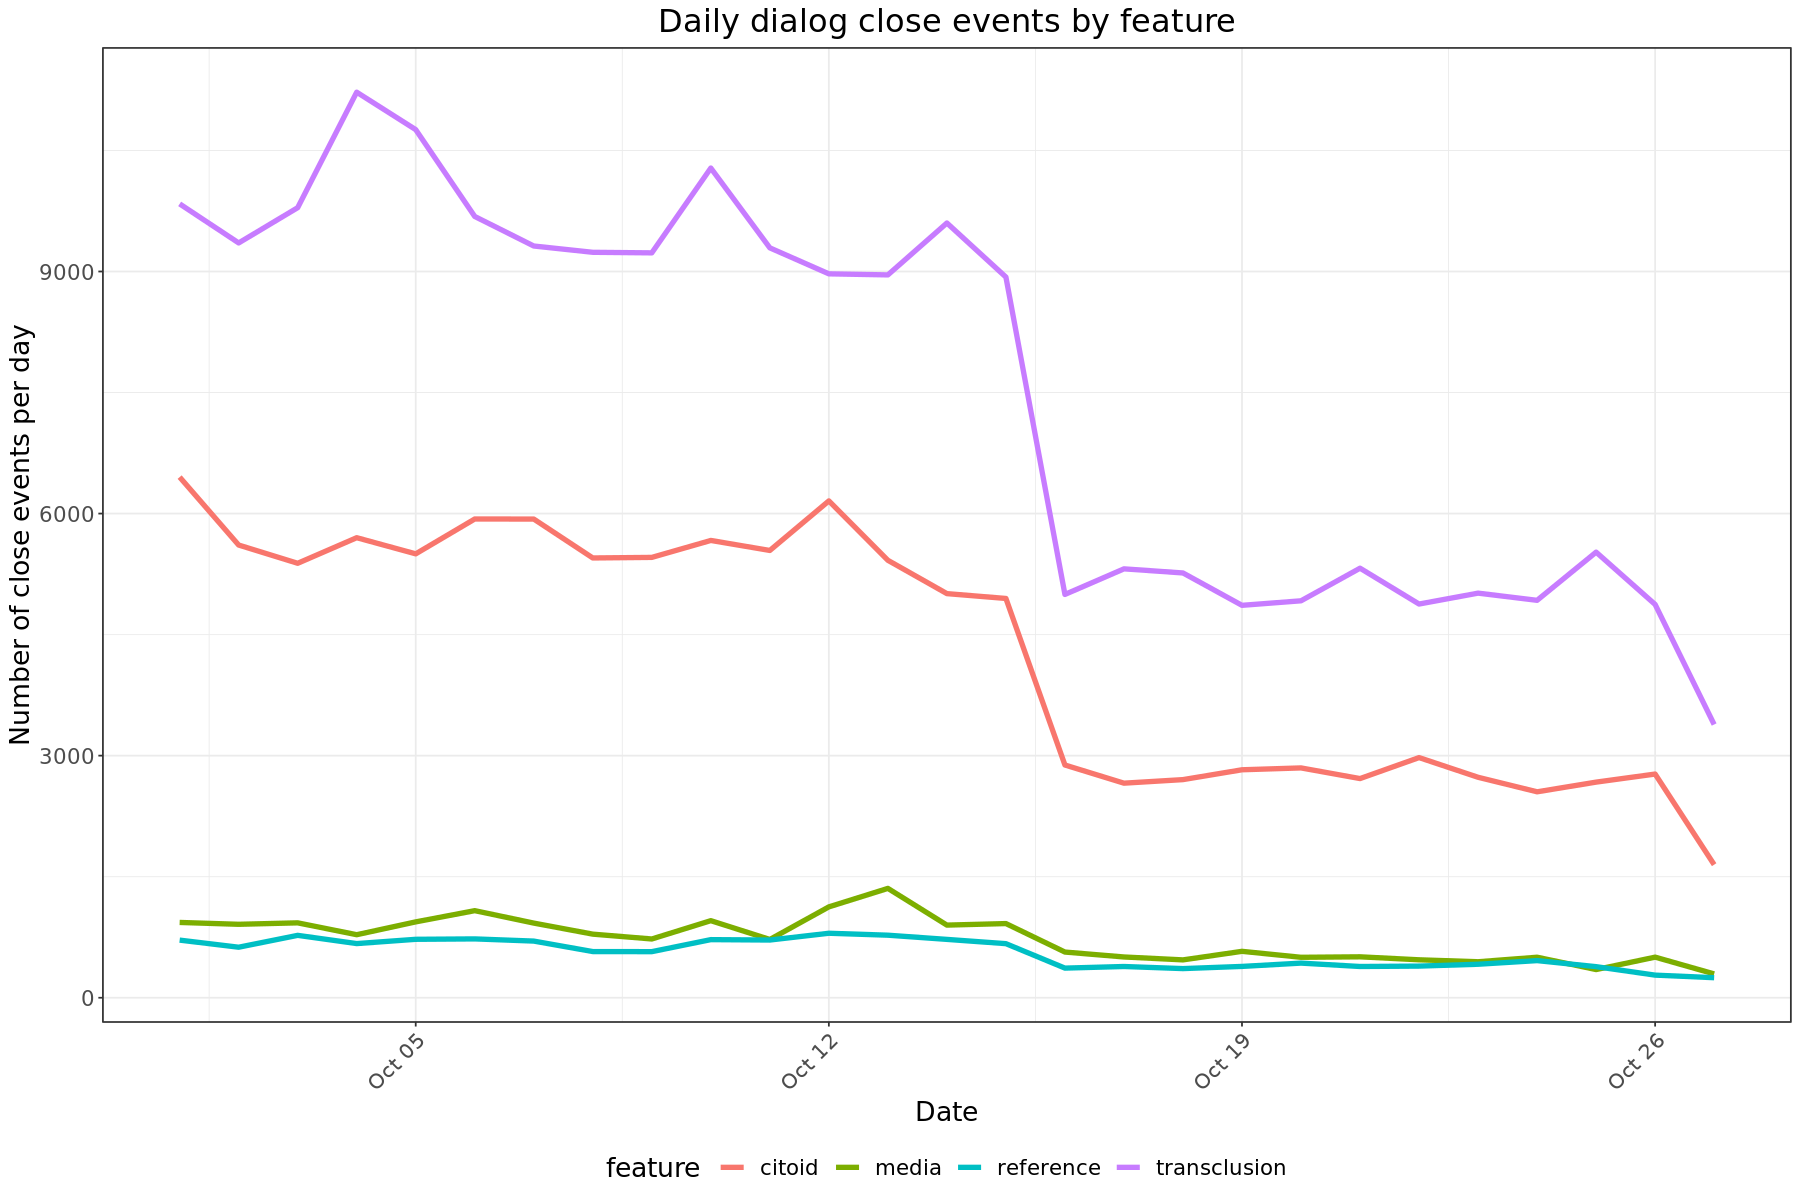

In [147]:
# Plot chart of duplicate events

p <- duplicate_events_daily %>%
    group_by(date, feature) %>%
    summarise(num_close_events = sum(dialog_close_event)) %>%
    ggplot(aes(x=date, y= num_close_events, color = feature)) +
    geom_line(size = 1.5) +
    scale_y_continuous() +
    labs (y = "Number of close events per day",
          x = "Date",
         title = "Daily dialog close events by feature")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = 'bottom') 
 
p

options(repr.plot.width = 15, repr.plot.height = 10)

In [148]:
ggsave("figures/daily_dialog_close_events.png", p, width = 16, height = 8, units = "in", dpi = 300)

`summarise()` regrouping output by 'date', 'feature' (override with `.groups` argument)



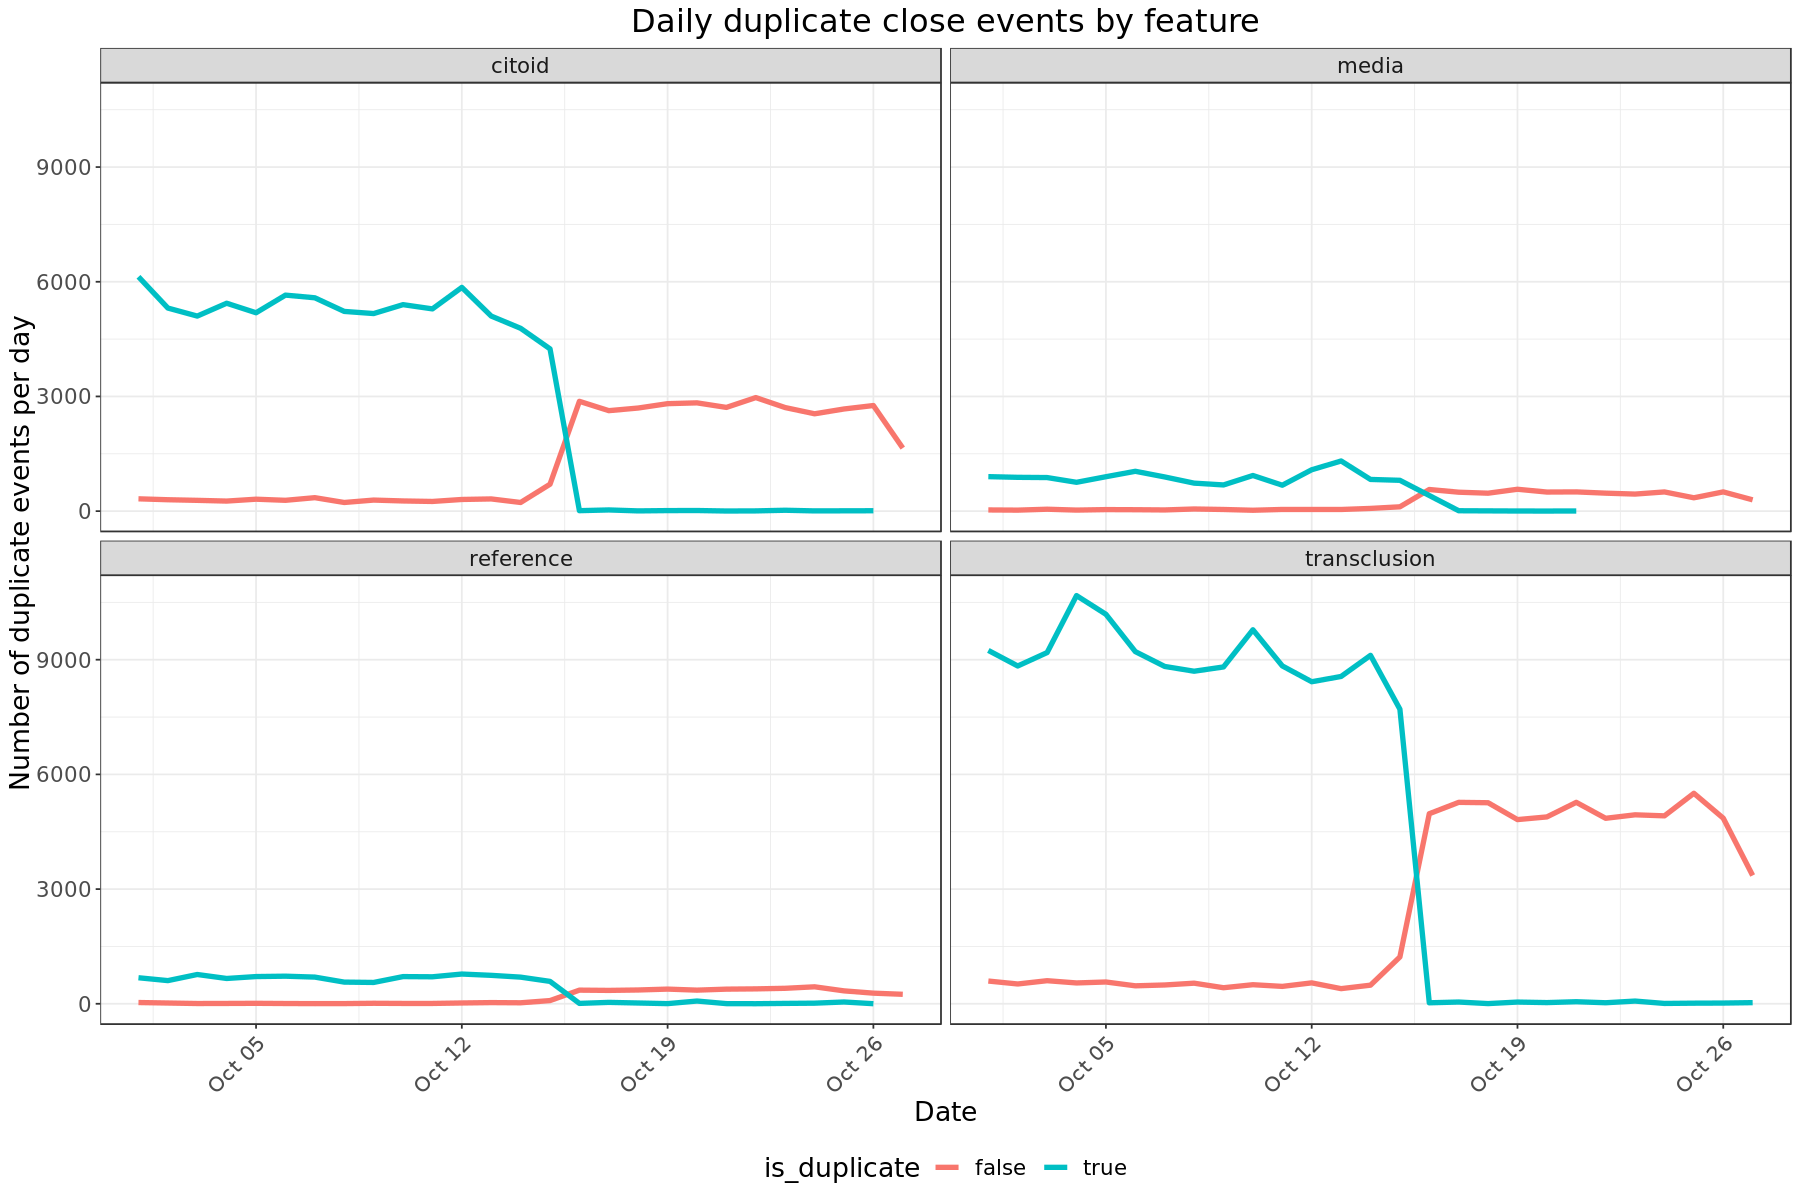

In [145]:
# plot duplicate events

p <- duplicate_events_daily %>%
    group_by(date, feature, is_duplicate) %>%
    summarise(num_close_events = sum(dialog_close_event)) %>%
    ggplot(aes(x=date, y= num_close_events, color = is_duplicate)) +
    facet_wrap(~feature) +
    geom_line(size = 1.5) +
    scale_y_continuous() +
    labs (y = "Number of duplicate events per day",
          x = "Date",
         title = "Daily duplicate close events by feature")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = 'bottom') 
 
p


In [146]:
ggsave("figures/daily_duplicate_events.png", p, width = 16, height = 8, units = "in", dpi = 300)